Perform transfer learning on Mobilenet

In [1]:
# Import VGG16 model
from keras.applications.mobilenet_v2 import MobileNetV2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, classification_report
from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow as tf
import cv2
fer_directory = 'data/FER2013'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
def plot_model_training(history):
    # Plot training & validation accuracy values
    plt.figure(facecolor='white')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy', fontsize=20)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.figure(facecolor='white')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss', fontsize=20)
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def calculate_model_metrics(y_true, y_pred, classes):
    # Calculate metrics
    print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=classes))

    # Calculate Precision, Recall, F1 score
    precision, recall, fscore, support = precision_recall_fscore_support(y_true, np.argmax(y_pred, axis=1), average='macro')
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", fscore)
    
    return precision, recall, fscore

def plot_confusion_matrix(y_true, y_pred, classes):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()
    
# Initialise generator with rescale factor 1./255
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=10,  zoom_range=0.1, horizontal_flip=True)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.5)

# Preprocess training set
train_generator = train_gen.flow_from_directory(
    fer_directory + '/train',
    target_size=(160,160),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_gen.flow_from_directory(
    fer_directory + '/test',
    target_size=(160,160),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Preprocess test set
# False shuffle so classification dont get mixed
test_generator = test_gen.flow_from_directory(
    fer_directory + '/test',
    target_size=(160,160),
    batch_size=64,
    class_mode='categorical',
    subset="validation",
    shuffle=False
)
# Try sprase categorical crossentropy
# Get steps per epoch
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Get classes and y labels
classes = list(test_generator.class_indices.keys())
y_true = test_generator.classes

Found 28709 images belonging to 7 classes.
Found 3591 images belonging to 7 classes.
Found 3587 images belonging to 7 classes.


In [3]:
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3), classes=7)

# Freeze layers
mobilenet.trainable = False

model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# Build model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 9

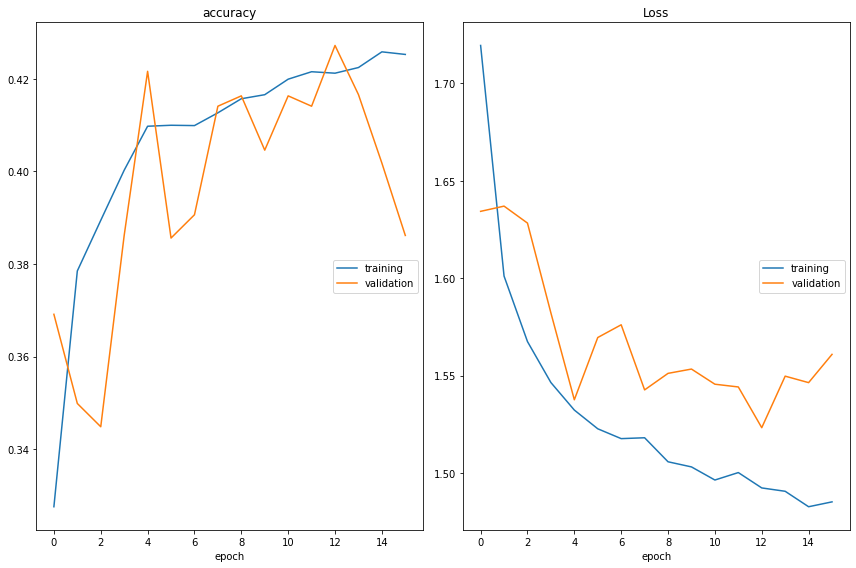

accuracy
	training         	 (min:    0.328, max:    0.426, cur:    0.425)
	validation       	 (min:    0.345, max:    0.427, cur:    0.386)
Loss
	training         	 (min:    1.483, max:    1.719, cur:    1.485)
	validation       	 (min:    1.523, max:    1.637, cur:    1.561)

Epoch 16: val_accuracy did not improve from 0.42718
448/448 [==============================] - 239s 533ms/step - loss: 1.4853 - accuracy: 0.4252 - val_loss: 1.5609 - val_accuracy: 0.3862 - lr: 0.0010
Epoch 17/40
323/448 [====================>.........] - ETA: 1:08 - loss: 1.4876 - accuracy: 0.4212

KeyboardInterrupt: 

In [4]:
# Train model
epoch = 40

# Load previous weights
# model.load_weights("weights/model_mobilenetv2.h5")

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, verbose=1, min_lr=0.00001)

# Stop training when a monitored metric has stopped improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

# Save the model after every epoch
checkpoint = ModelCheckpoint("weights/model_mobilenetv2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[PlotLossesKeras(), reduce_lr, early_stop, checkpoint]
)

In [21]:
# Print number of trainable and non-trainable parameters
print("Number of layers in the base model: ", len(mobilenet.layers))


Number of layers in the base model:  154


In [22]:
# Try training top layer as well to see if it improves val accuracy

# Unfreeze layers
mobilenet.trainable = True

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all layers before the `fine_tune_at` layer
for layer in mobilenet.layers[:fine_tune_at]:
    layer.trainable = False
    
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

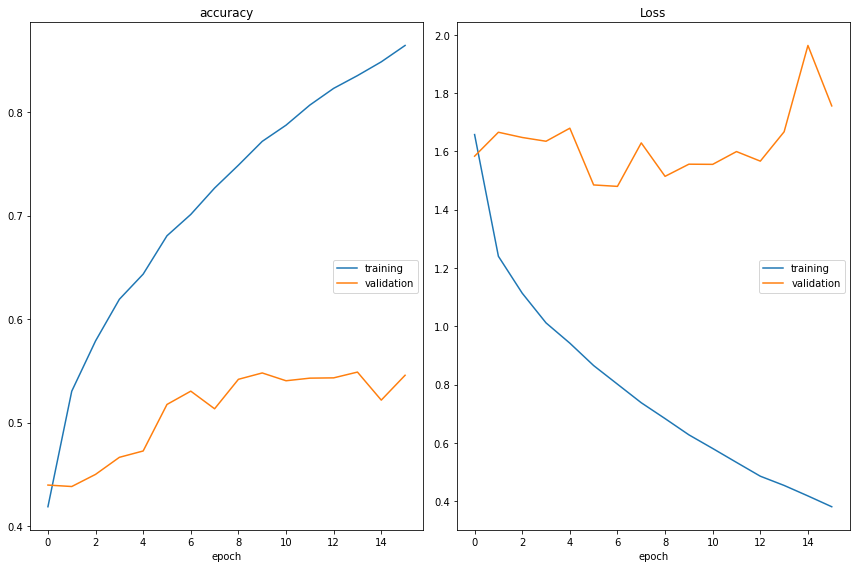

accuracy
	training         	 (min:    0.419, max:    0.864, cur:    0.864)
	validation       	 (min:    0.438, max:    0.549, cur:    0.546)
Loss
	training         	 (min:    0.381, max:    1.658, cur:    0.381)
	validation       	 (min:    1.480, max:    1.964, cur:    1.756)

Epoch 16: val_accuracy did not improve from 0.54883
224/224 [==============================] - 96s 429ms/step - loss: 0.3807 - accuracy: 0.8642 - val_loss: 1.7561 - val_accuracy: 0.5458 - lr: 1.0000e-04
Epoch 17/40
 85/224 [==========>...................] - ETA: 57s - loss: 0.3314 - accuracy: 0.8831

KeyboardInterrupt: 

In [23]:
epoch = 40

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[PlotLossesKeras(), reduce_lr, early_stop, checkpoint]
)
